#### SPEECH TO TEXT MODEL WITH DL AND NLP

#### Import Section

In [7]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

#### Visualization of Audio signal in time series domain

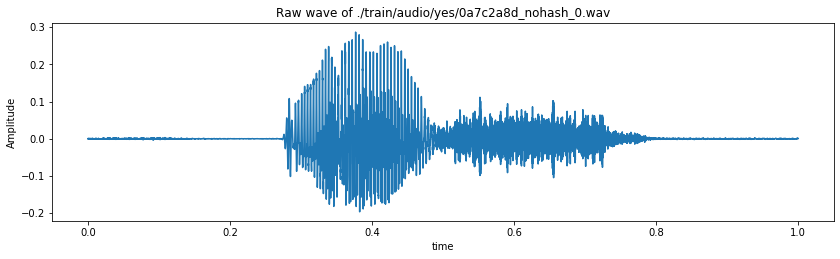

In [17]:
train_audio_path = './train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + './train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

#### Sampling Rate

In [18]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


Sampling rate of the signal is 16,000 Hz. Lets Re-sample it to 8000 Hz since most of the speech-related frequencies are present at 8000 Hz:

#### Resampling

In [19]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

#### Finding number of recordings for each voice command

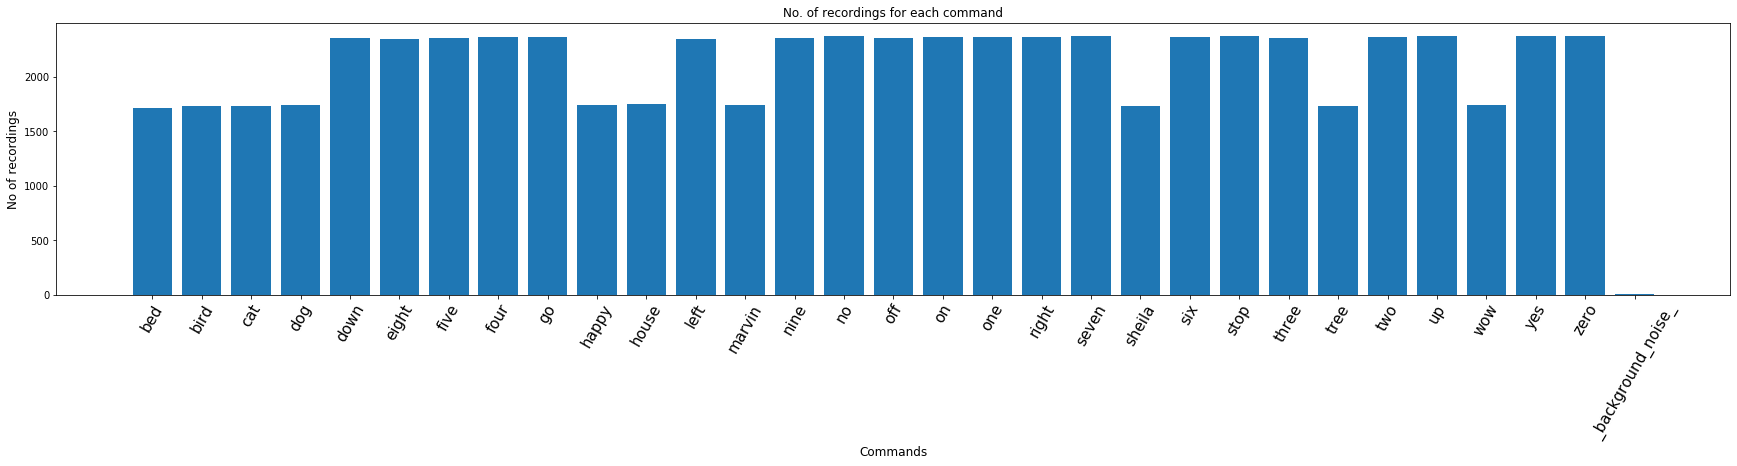

In [20]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

#### Duration of recordings

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

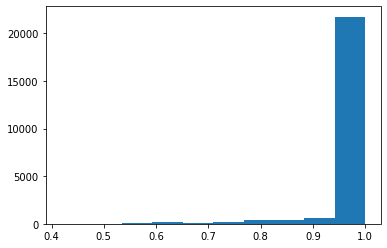

In [21]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

#### Preprocessing the audio waves

Few recordings' duration is less than 1 second and the sampling rate is too high. So, let us read the audio waves and use the below-preprocessing steps to deal with this.

Here are the two steps we’ll follow:

-Resampling

-Removing shorter commands of less than 1 second


In [22]:
train_audio_path = './train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


Convert the output labels to integer encoded:

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

Now, convert the integer encoded labels to a one-hot vector since it is a multi-classification problem:

In [29]:
import tensorflow
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:

In [30]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

Train set and Validation set split

In [31]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

Model Building

In [40]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

Loss function to be categorical cross-entropy since it is a multi-classification problem:

In [41]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch: 

In [42]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Let us train the model on a batch size of 32 and evaluate the performance on the holdout set: 

In [43]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Train on 17049 samples, validate on 4263 samples
Epoch 1/100
17024/17049 [============================>.] - ETA: 0s - loss: 2.0269 - accuracy: 0.2347

W0309 21:23:21.057297 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 70s 4ms/sample - loss: 2.0264 - accuracy: 0.2351 - val_loss: 1.5998 - val_accuracy: 0.4199
Epoch 2/100
17024/17049 [============================>.] - ETA: 0s - loss: 1.4790 - accuracy: 0.4537

W0309 21:24:32.044846 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 71s 4ms/sample - loss: 1.4791 - accuracy: 0.4536 - val_loss: 1.2485 - val_accuracy: 0.5724
Epoch 3/100
17024/17049 [============================>.] - ETA: 0s - loss: 1.2206 - accuracy: 0.5654

W0309 21:25:42.839292 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 71s 4ms/sample - loss: 1.2202 - accuracy: 0.5654 - val_loss: 1.0337 - val_accuracy: 0.6507
Epoch 4/100
17024/17049 [============================>.] - ETA: 0s - loss: 1.0563 - accuracy: 0.6256

W0309 21:26:54.004830 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 71s 4ms/sample - loss: 1.0558 - accuracy: 0.6259 - val_loss: 0.8763 - val_accuracy: 0.7122
Epoch 5/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.9510 - accuracy: 0.6680

W0309 21:28:09.520761 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 76s 4ms/sample - loss: 0.9507 - accuracy: 0.6681 - val_loss: 0.8583 - val_accuracy: 0.7084
Epoch 6/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.8436 - accuracy: 0.7102

W0309 21:29:26.279070 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 77s 5ms/sample - loss: 0.8439 - accuracy: 0.7101 - val_loss: 0.7235 - val_accuracy: 0.7645
Epoch 7/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.7832 - accuracy: 0.7313

W0309 21:30:39.067253 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 73s 4ms/sample - loss: 0.7828 - accuracy: 0.7315 - val_loss: 0.7305 - val_accuracy: 0.7532
Epoch 8/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.7185 - accuracy: 0.7509

W0309 21:31:52.078658 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 73s 4ms/sample - loss: 0.7180 - accuracy: 0.7511 - val_loss: 0.6752 - val_accuracy: 0.7713
Epoch 9/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.7699

W0309 21:33:02.496659 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 70s 4ms/sample - loss: 0.6705 - accuracy: 0.7698 - val_loss: 0.6429 - val_accuracy: 0.7903
Epoch 10/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.6224 - accuracy: 0.7908

W0309 21:34:14.537080 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 72s 4ms/sample - loss: 0.6229 - accuracy: 0.7908 - val_loss: 0.6789 - val_accuracy: 0.7675
Epoch 11/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.5990 - accuracy: 0.7935

W0309 21:35:26.551093 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 72s 4ms/sample - loss: 0.5989 - accuracy: 0.7935 - val_loss: 0.5854 - val_accuracy: 0.8053
Epoch 12/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.5479 - accuracy: 0.8125

W0309 21:36:37.961945 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 71s 4ms/sample - loss: 0.5478 - accuracy: 0.8125 - val_loss: 0.5887 - val_accuracy: 0.8032
Epoch 13/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.5454 - accuracy: 0.8087

W0309 21:37:49.586066 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 72s 4ms/sample - loss: 0.5451 - accuracy: 0.8088 - val_loss: 0.5905 - val_accuracy: 0.8018
Epoch 14/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.5126 - accuracy: 0.8240

W0309 21:39:00.758958 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 71s 4ms/sample - loss: 0.5123 - accuracy: 0.8242 - val_loss: 0.5693 - val_accuracy: 0.8147
Epoch 15/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.4835 - accuracy: 0.8304

W0309 21:40:11.792897 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 71s 4ms/sample - loss: 0.4834 - accuracy: 0.8304 - val_loss: 0.5969 - val_accuracy: 0.8006
Epoch 16/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.4674 - accuracy: 0.8386

W0309 21:41:22.926873 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 71s 4ms/sample - loss: 0.4677 - accuracy: 0.8385 - val_loss: 0.5462 - val_accuracy: 0.8255
Epoch 17/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.4465 - accuracy: 0.8465

W0309 21:42:34.136980 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 71s 4ms/sample - loss: 0.4466 - accuracy: 0.8464 - val_loss: 0.5549 - val_accuracy: 0.8149
Epoch 18/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.4401 - accuracy: 0.8465

W0309 21:43:45.519572 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 71s 4ms/sample - loss: 0.4402 - accuracy: 0.8463 - val_loss: 0.5544 - val_accuracy: 0.8191
Epoch 19/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.4362 - accuracy: 0.8515

W0309 21:44:58.238378 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 73s 4ms/sample - loss: 0.4360 - accuracy: 0.8515 - val_loss: 0.5463 - val_accuracy: 0.8234
Epoch 20/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.4193 - accuracy: 0.8567

W0309 21:46:09.880858 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 72s 4ms/sample - loss: 0.4189 - accuracy: 0.8568 - val_loss: 0.5433 - val_accuracy: 0.8205
Epoch 21/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.3907 - accuracy: 0.8658

W0309 21:47:20.972157 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 71s 4ms/sample - loss: 0.3907 - accuracy: 0.8659 - val_loss: 0.5200 - val_accuracy: 0.8323
Epoch 22/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.3898 - accuracy: 0.8661

W0309 21:48:32.984477 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 72s 4ms/sample - loss: 0.3896 - accuracy: 0.8662 - val_loss: 0.5219 - val_accuracy: 0.8320
Epoch 23/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.3777 - accuracy: 0.8708

W0309 21:49:43.367809 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 70s 4ms/sample - loss: 0.3790 - accuracy: 0.8706 - val_loss: 0.5406 - val_accuracy: 0.8245
Epoch 24/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.3594 - accuracy: 0.8764

W0309 21:50:54.029833 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 71s 4ms/sample - loss: 0.3594 - accuracy: 0.8764 - val_loss: 0.5169 - val_accuracy: 0.8323
Epoch 25/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.3694 - accuracy: 0.8742

W0309 21:52:03.949964 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 70s 4ms/sample - loss: 0.3698 - accuracy: 0.8741 - val_loss: 0.6126 - val_accuracy: 0.7973
Epoch 26/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.3454 - accuracy: 0.8830

W0309 21:53:13.641190 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 70s 4ms/sample - loss: 0.3453 - accuracy: 0.8830 - val_loss: 0.4952 - val_accuracy: 0.8461
Epoch 27/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.3332 - accuracy: 0.8866

W0309 21:54:25.429625 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 72s 4ms/sample - loss: 0.3329 - accuracy: 0.8867 - val_loss: 0.5101 - val_accuracy: 0.8440
Epoch 28/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.3295 - accuracy: 0.8852

W0309 21:55:36.063841 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 71s 4ms/sample - loss: 0.3296 - accuracy: 0.8851 - val_loss: 0.5599 - val_accuracy: 0.8323
Epoch 29/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.3182 - accuracy: 0.8920

W0309 21:56:48.031069 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 72s 4ms/sample - loss: 0.3181 - accuracy: 0.8920 - val_loss: 0.5114 - val_accuracy: 0.8367
Epoch 30/100
17024/17049 [============================>.] - ETA: 9s - loss: 0.3110 - accuracy: 0.8922 

W0309 23:44:11.909065 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 6444s 378ms/sample - loss: 0.3107 - accuracy: 0.8923 - val_loss: 0.5209 - val_accuracy: 0.8379
Epoch 31/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8941

W0309 23:45:45.677620 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 94s 5ms/sample - loss: 0.3122 - accuracy: 0.8942 - val_loss: 0.5232 - val_accuracy: 0.8407
Epoch 32/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.8938

W0309 23:47:20.934635 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 95s 6ms/sample - loss: 0.3139 - accuracy: 0.8938 - val_loss: 0.5042 - val_accuracy: 0.8473
Epoch 33/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.3019 - accuracy: 0.8973

W0309 23:48:57.045068 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 96s 6ms/sample - loss: 0.3019 - accuracy: 0.8973 - val_loss: 0.5153 - val_accuracy: 0.8447
Epoch 34/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.2907 - accuracy: 0.9018

W0309 23:50:34.551243 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 98s 6ms/sample - loss: 0.2906 - accuracy: 0.9018 - val_loss: 0.5671 - val_accuracy: 0.8283
Epoch 35/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.9023

W0309 23:52:18.152543 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 104s 6ms/sample - loss: 0.2882 - accuracy: 0.9023 - val_loss: 0.5168 - val_accuracy: 0.8440
Epoch 36/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.2935 - accuracy: 0.8998

W0309 23:54:05.447495 22564 callbacks.py:1018] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 107s 6ms/sample - loss: 0.2938 - accuracy: 0.8996 - val_loss: 0.5236 - val_accuracy: 0.8456
Epoch 00036: early stopping


Model Performance on Train set and Test set

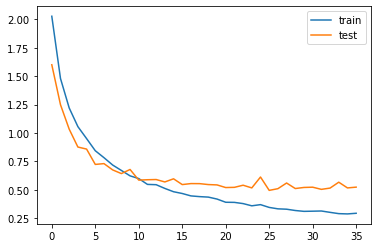

In [45]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [ ]:
# from keras.models import load_model
# model=load_model('best_model.hdf5')

Function that predicts text for the given audio: 

In [61]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

Prediction time! Make predictions on the validation data:

In [48]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: down
Text: down


Record your voice sample

In [67]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [69]:
samplerate = 16000  
duration = 1 # seconds
filename = 'left.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


Predicting newly recorded sample

In [73]:
#reading the voice commands
samples, sample_rate = librosa.load('left.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  
predict(samples)

'left'

In [74]:
samples, sample_rate = librosa.load('yes.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  
predict(samples)

'yes'